# Example for the Beijing Air Quality 2.5 Dataset

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
!pip install dill
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import dill
import shap
import tensorflow as tf
import sys
sys.path.append("/content/drive/MyDrive/Nadiyah/final_codes")

In [ ]:
#python version 3..8
import sys
sys.path.append("/content/drive/MyDrive/Nadiyah/final_codes/ts-mule_main")
sys.path.append("/content/drive/MyDrive/Nadiyah/final_codes/Window_Shap")
import dill

import numpy as np
import pandas as pd
import timeit
import tensorflow as tf     #tensorflow version 2.10.0

import matplotlib.pyplot as plt
import shap
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from tsmule.xai.lime import LimeTS
from tsmule.sampling.segment import WindowSegmentation, MatrixProfileSegmentation, SAXSegmentation
from tsmule.sampling.perturb import Perturbation
from tsmule.xai.evaluation import PerturbationAnalysis
import windowshap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Nadiyah/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_cnn_model.h5')

with open('/content/drive/MyDrive/Nadiyah/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_test_data.dill', 'rb') as f:
    dataset_test = dill.load(f)

In [ ]:
sample=dataset_test[0]
labels=dataset_test[1]

In [ ]:
def predict_fn(x):
    if len(x.shape) == 2:
        prediction = cnn_model.predict(x[np.newaxis, :, :]).ravel()
    else:
        prediction = cnn_model.predict(x).ravel()
    return prediction

## Create Explanations

### Explanations with SHAP

In [ ]:
import timeit
tic=timeit.default_timer()
shap_exp=shap.DeepExplainer(cnn_model, sample[:3000]) #expected shape (None, 24, 7)

shap_values=shap_exp.shap_values(sample)

shap_values

print('Total time: ' + str(timeit.default_timer()-tic))

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Total time: 1814.5789416440002


In [ ]:
shap_values=np.asarray(shap_values).squeeze()
shap_values.shape

(8347, 24, 7)

In [ ]:
with open('Beijing_air_quality_cnn_shap_values.dill', 'wb') as f:
    dill.dump(shap_values, f)

### Explanation by Window Segmentation

In [ ]:
lasso_classifier = linear_model.Lasso(alpha=0.01)  #faster the model, faster LIME works
per=Perturbation() #perturbation object for LimeTS object, sampler

In [ ]:
#LimeTS object for uniform segmentation
tic = timeit.default_timer()

#segments object, WindowSegmentation object has stationery and exponential segmentations techniques
uniform_seg=WindowSegmentation(partitions=4, win_length=24)
uniform_lime=LimeTS(kernel=lasso_classifier, segmenter=uniform_seg, sampler=per, n_samples=24)
lime_values_uni=[uniform_lime.explain(sample[i], predict_fn, segmentation_method='uniform')
                 for i in range(len(sample))]

print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


In [ ]:
with open("Beijing_air_quality_cnn_lime_values_uni.dill", 'wb') as f:
    dill.dump(lime_values_uni, f)

### Explanation with Exponential Window Segmentation

In [ ]:
#LimeTS object for exponential window segmentation
tic = timeit.default_timer()
#segment object, WindowSegmentation has stationery and exponentials segmentation techniques
exp_seg=WindowSegmentation(partitions=4, win_length=24)
exp_lime=LimeTS(kernel=lasso_classifier, segmenter=exp_seg, sampler=per, n_samples=24)
#explainer for LimeTS
lime_values_exp=[exp_lime.explain(sample[i], predict_fn, segmentation_method='exponential')
                 for i in range(len(sample))]

print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - ETA: 0s

In [ ]:
with open("Beijing_air_quality_cnn_lime_values_exp.dill", 'wb') as f:
    dill.dump(lime_values_exp, f)

### Explanations with LIME and MatrixProfile Segmentation

##### Slopes-Sorted

In [ ]:
#LimeTS object for matrix profile segmentation= slopes-sorted
tic=timeit.default_timer()
#segment object, MatrixProfileSegmentation object has slopes, bins-min, bins-max segmentation techniques
seg_slopes=MatrixProfileSegmentation(partitions=4, win_length=20)

lime_slopes=LimeTS(kernel=lasso_classifier, segmenter=seg_slopes, sampler=per)
lime_values_slopes=[lime_slopes.explain(sample[i], predict_fn,
                                                  segmentation_method='slopes-sorted') for i in
                    range(len(sample))]

print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - ETA: 0s

In [ ]:
with open("Beijing_air_quality_cnn_lime_values_slopes.dill", 'wb') as f:
    dill.dump(lime_values_slopes, f)

### Explanations with LIME and SAX Transformations

In [ ]:
#LimeTS object for SAX segmentation
tic=timeit.default_timer()
#create segment object for SAX Transformation
seg_sax=SAXSegmentation(partitions=4, win_length=10)

lime_sax=LimeTS(kernel=lasso_classifier, segmenter=seg_sax, sampler=per, n_samples=24)
lime_values_sax=[lime_sax.explain(sample[i], predict_fn) for i in range(len(sample))]

print('Total time: ' + str(timeit.default_timer()-tic))

1/1 [==============================] - ETA: 0s

In [ ]:
with open("Beijing_air_quality_cnn_lime_values_sax.dill", 'wb') as f:
    dill.dump(lime_values_sax, f)

In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.6 MB/s eta 0:00:00


In [ ]:
pip install pandas

In [ ]:
import dill
import pandas as pd

In [ ]:
with open('/content/drive/MyDrive/EXTRA/Nadiyah/final_codes/shap_values/beijing_air_rnn_shap_values.dill', 'rb') as f:
    data = dill.load(f)


In [ ]:
data


array([[[-4.41705692e-04,  4.39671567e-04,  1.25924533e-03, ...,
          7.41403055e-05,  3.47994114e-06, -1.14016484e-05],
        [ 5.97291046e-06,  8.07931123e-04, -1.55655842e-04, ...,
          2.50671437e-05,  4.88899286e-06, -1.06097159e-05],
        [-3.12581455e-04,  6.51847338e-04,  1.57344958e-03, ...,
          8.94456025e-05, -1.61558884e-04,  4.88982732e-06],
        ...,
        [-5.95895399e-04,  2.58318335e-03, -8.28302931e-04, ...,
         -2.20300557e-04,  2.08564006e-06, -2.80592176e-05],
        [-2.75930477e-04,  2.05192715e-03, -4.18748939e-04, ...,
         -1.68736980e-04,  3.90263540e-06, -1.69032664e-05],
        [-3.73788236e-04,  1.73233019e-03, -5.67953102e-04, ...,
          2.04492244e-05,  3.09558641e-06, -9.78468393e-07]],

       [[ 1.41083135e-03, -9.00170708e-05, -1.27347489e-03, ...,
          3.80667218e-04,  3.47994114e-06, -1.14016484e-05],
        [ 6.90445086e-05, -5.71424258e-04, -1.72794404e-04, ...,
          1.47591185e-04,  4.88899286e

In [ ]:
data.shape

(8347, 24, 7)

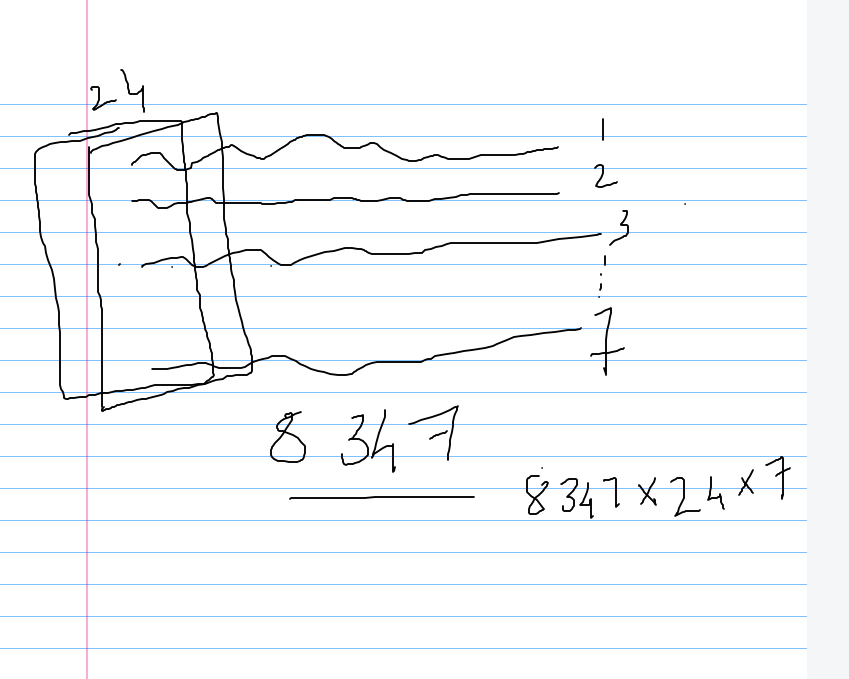

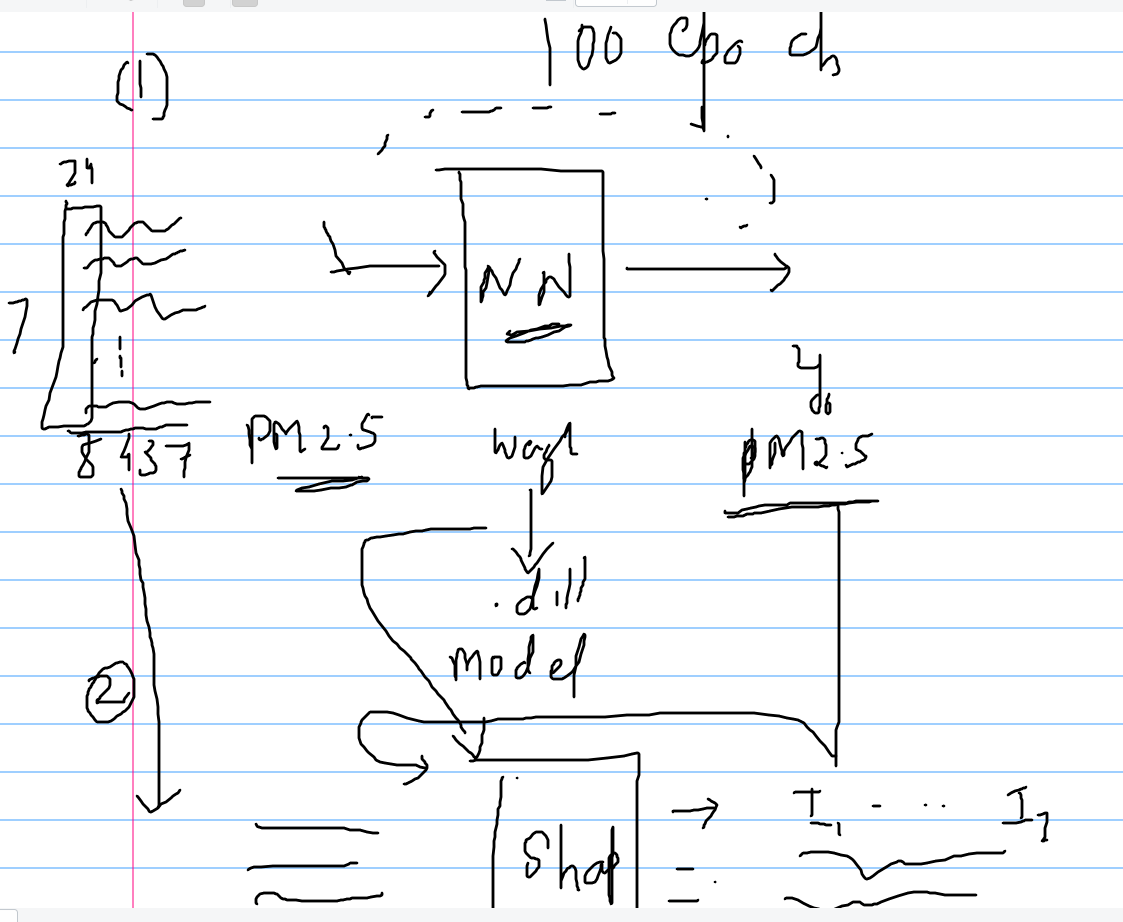